<a href="https://colab.research.google.com/github/andreiolar77/APS-Labs/blob/main/APS_CarVis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# CNN and lane detection


**APS Project Basics**

Import packages that could stand to prove useful. The majority of these packages are pulled straight from Lab 3 and it's packages.

In [ ]:
#useful packages
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import operator
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import time
import os
import shutil
import pandas as pd

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
#import splitfolders

Major Goal?
- Devise a Regional Convolutional Neural Network whose goal is to perform the tasks that would typically be mediated by a "Lane Detection" software in a car.
  - This be would include but not limited to:
  - Detect various types of street divisors across the world (our dataset comprises images from Italy, China and Canada)
  - Detect various forms of traffic signs and what they may mean
  - Basic pedestrian detection software
  - Discern these street divisors in hazy, foggy, dark, or blurry (high speed) situations.
  

*Implemented Feature Highlight:*

Utilization of previous frames (in our case the previous 5) to help predict the new set-up of concurrent and future frames.


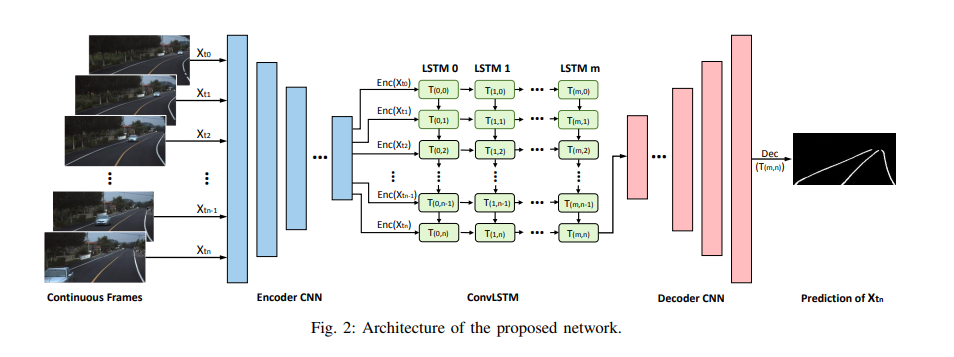


The previous image highlights the basis of the model proposed, using a autoencoder network in tandem with a Convolutional network to help achieve the accuracy improvements. To what magnitude? Accuracy, Precision and Recall all showed significant improvement in this paper in "difficult situations", where light was dim, objects obscured the path, turns were sharp, etc...

(https://arxiv.org/pdf/1903.02193.pdf)


In [ ]:
import torch
import config
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from utils import *
import operator
from config import args_setting

def generate_model(args):

    use_cuda = args.cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    assert args.model in [ 'UNet-ConvLSTM', 'SegNet-ConvLSTM', 'UNet', 'SegNet']
    if args.model == 'SegNet-ConvLSTM':
        model = SegNet_ConvLSTM().to(device)
    elif args.model == 'SegNet':
        model = SegNet().to(device)
    elif args.model == 'UNet-ConvLSTM':
        model =UNet_ConvLSTM(config.img_channel, config.class_num).to(device)
    elif args.model == 'UNet':
        model = UNet(config.img_channel, config.class_num).to(device)
    return model

class UNet_ConvLSTM(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet_ConvLSTM, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)
        self.convlstm = ConvLSTM(input_size=(8,16),
                                 input_dim=512,
                                 hidden_dim=[512, 512],
                                 kernel_size=(3,3),
                                 num_layers=2,
                                 batch_first=False,
                                 bias=True,
                                 return_all_layers=False)

    def forward(self, x):
        x = torch.unbind(x, dim=1)
        data = []
        for item in x:
            x1 = self.inc(item)
            x2 = self.down1(x1)
            x3 = self.down2(x2)
            x4 = self.down3(x3)
            x5 = self.down4(x4)
            data.append(x5.unsqueeze(0))
        data = torch.cat(data, dim=0)
        lstm, _ = self.convlstm(data)
        test = lstm[0][ -1,:, :, :, :]
        x = self.up1(test, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x, test


class SegNet_ConvLSTM(nn.Module):
    def __init__(self):
        super(SegNet_ConvLSTM,self).__init__()
        self.vgg16_bn = models.vgg16_bn(pretrained=True).features
        self.relu = nn.ReLU(inplace=True)
        self.index_MaxPool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.index_UnPool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # net struct
        self.conv1_block = nn.Sequential(self.vgg16_bn[0],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[1],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[2],  # relu(in_place)
                                         self.vgg16_bn[3],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[4],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[5]   # relu(in_place)
                                         )
        self.conv2_block = nn.Sequential(self.vgg16_bn[7],
                                         self.vgg16_bn[8],
                                         self.vgg16_bn[9],
                                         self.vgg16_bn[10],
                                         self.vgg16_bn[11],
                                         self.vgg16_bn[12]
                                         )
        self.conv3_block = nn.Sequential(self.vgg16_bn[14],
                                         self.vgg16_bn[15],
                                         self.vgg16_bn[16],
                                         self.vgg16_bn[17],
                                         self.vgg16_bn[18],
                                         self.vgg16_bn[19],
                                         self.vgg16_bn[20],
                                         self.vgg16_bn[21],
                                         self.vgg16_bn[22]
                                         )
        self.conv4_block = nn.Sequential(self.vgg16_bn[24],
                                         self.vgg16_bn[25],
                                         self.vgg16_bn[26],
                                         self.vgg16_bn[27],
                                         self.vgg16_bn[28],
                                         self.vgg16_bn[29],
                                         self.vgg16_bn[30],
                                         self.vgg16_bn[31],
                                         self.vgg16_bn[32]
                                         )
        self.conv5_block = nn.Sequential(self.vgg16_bn[34],
                                         self.vgg16_bn[35],
                                         self.vgg16_bn[36],
                                         self.vgg16_bn[37],
                                         self.vgg16_bn[38],
                                         self.vgg16_bn[39],
                                         self.vgg16_bn[40],
                                         self.vgg16_bn[41],
                                         self.vgg16_bn[42]
                                         )

        self.upconv5_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv4_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv3_block = nn.Sequential(
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv2_block = nn.Sequential(
                                           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu
                                           )
        self.upconv1_block = nn.Sequential(
                                           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(64, config.class_num, kernel_size=(3, 3), padding=(1,1)),
                                           )
        self.convlstm = ConvLSTM(input_size=(4,8),
                                 input_dim=512,
                                 hidden_dim=[512, 512],
                                 kernel_size=(3,3),
                                 num_layers=2,
                                 batch_first=False,
                                 bias=True,
                                 return_all_layers=False)
    def forward(self, x):
        x = torch.unbind(x, dim=1)
        data = []
        for item in x:
            f1, idx1 = self.index_MaxPool(self.conv1_block(item))
            f2, idx2 = self.index_MaxPool(self.conv2_block(f1))
            f3, idx3 = self.index_MaxPool(self.conv3_block(f2))
            f4, idx4 = self.index_MaxPool(self.conv4_block(f3))
            f5, idx5 = self.index_MaxPool(self.conv5_block(f4))
            data.append(f5.unsqueeze(0))
        data = torch.cat(data, dim=0)
        lstm, _ = self.convlstm(data)
        test = lstm[0][-1,:,:,:,:]
        up6 = self.index_UnPool(test,idx5)
        up5 = self.index_UnPool(self.upconv5_block(up6), idx4)
        up4 = self.index_UnPool(self.upconv4_block(up5), idx3)
        up3 = self.index_UnPool(self.upconv3_block(up4), idx2)
        up2 = self.index_UnPool(self.upconv2_block(up3), idx1)
        up1 = self.upconv1_block(up2)
        return F.log_softmax(up1, dim=1)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x


class SegNet(nn.Module):
    def __init__(self):
        super(SegNet,self).__init__()
        self.vgg16_bn = models.vgg16_bn(pretrained=True).features
        self.relu = nn.ReLU(inplace=True)
        self.index_MaxPool = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)
        self.index_UnPool = nn.MaxUnpool2d(kernel_size=2, stride=2)
        # net struct
        self.conv1_block = nn.Sequential(self.vgg16_bn[0],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[1],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[2],  # relu(in_place)
                                         self.vgg16_bn[3],  # conv2d(3,64,(3,3))
                                         self.vgg16_bn[4],  # bn(64,eps=1e-05,momentum=0.1,affine=True)
                                         self.vgg16_bn[5]   # relu(in_place)
                                         )
        self.conv2_block = nn.Sequential(self.vgg16_bn[7],
                                         self.vgg16_bn[8],
                                         self.vgg16_bn[9],
                                         self.vgg16_bn[10],
                                         self.vgg16_bn[11],
                                         self.vgg16_bn[12]
                                         )
        self.conv3_block = nn.Sequential(self.vgg16_bn[14],
                                         self.vgg16_bn[15],
                                         self.vgg16_bn[16],
                                         self.vgg16_bn[17],
                                         self.vgg16_bn[18],
                                         self.vgg16_bn[19],
                                         self.vgg16_bn[20],
                                         self.vgg16_bn[21],
                                         self.vgg16_bn[22]
                                         )
        self.conv4_block = nn.Sequential(self.vgg16_bn[24],
                                         self.vgg16_bn[25],
                                         self.vgg16_bn[26],
                                         self.vgg16_bn[27],
                                         self.vgg16_bn[28],
                                         self.vgg16_bn[29],
                                         self.vgg16_bn[30],
                                         self.vgg16_bn[31],
                                         self.vgg16_bn[32]
                                         )
        self.conv5_block = nn.Sequential(self.vgg16_bn[34],
                                         self.vgg16_bn[35],
                                         self.vgg16_bn[36],
                                         self.vgg16_bn[37],
                                         self.vgg16_bn[38],
                                         self.vgg16_bn[39],
                                         self.vgg16_bn[40],
                                         self.vgg16_bn[41],
                                         self.vgg16_bn[42]
                                         )

        self.upconv5_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv4_block = nn.Sequential(
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv3_block = nn.Sequential(
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(256, 128, kernel_size=(3, 3), padding=(1, 1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           )
        self.upconv2_block = nn.Sequential(
                                           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu
                                           )
        self.upconv1_block = nn.Sequential(
                                           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1,1)),
                                           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
                                           self.relu,
                                           nn.Conv2d(64, config.class_num, kernel_size=(3, 3), padding=(1,1)),
                                           )
    def forward(self, x):
        f1, idx1 = self.index_MaxPool(self.conv1_block(x))
        f2, idx2 = self.index_MaxPool(self.conv2_block(f1))
        f3, idx3 = self.index_MaxPool(self.conv3_block(f2))
        f4, idx4 = self.index_MaxPool(self.conv4_block(f3))
        f5, idx5 = self.index_MaxPool(self.conv5_block(f4))
        up6 = self.index_UnPool(f5,idx5)
        up5 = self.index_UnPool(self.upconv5_block(up6), idx4)
        up4 = self.index_UnPool(self.upconv4_block(up5), idx3)
        up3 = self.index_UnPool(self.upconv3_block(up4), idx2)
        up2 = self.index_UnPool(self.upconv2_block(up3), idx1)
        up1 = self.upconv1_block(up2)

        return F.log_softmax(up1, dim=1)

ModuleNotFoundError: ignored

We can define a loss function with cross entropy:

E = ∑ 𝑊(x)×log(softmax(x))

where x is defined as a singular sample pixel position.

We should also will incorporate two seperate gradient descent functions to help us train our system.

These are Adam for our "beginning" stages, where the network still needs significant tuning, and a stochastic gradient descent algorithm for the latter end of our training cycles.

The reason for this choice is that, whilst Adam is powerful, it has a higher gradient descending rate, which can lead it to more easily fall into local minima. After sufficient training, we will utilize a SGD algorithm to find the strongest contender for the global maximum.

In [ ]:
def loss():
  

# Baseline Model

A reasonable choice for this project's baseline mode would be either a heuristic model that connects points that join the lane, basically fitting points to some polynomial function or a function that marks a "line" of different color than the rest of the background.

Though the first choice is reasonable, it would just function as a hardcoded polynomial fitting function, which whilst somewhat relevant, does not completely encapsulate the basic premise of what we are trying to do with this model. Though some data points do have labels 

^is this true lol?

that connect the different segments of the lane, this is not all of them and it is not what we want our model to do. Though we may have to perform third-degree curve fitting to get the best possible fit for "curvier" sections of road, our ultimate goal is to detect some section of an image that is different from the rest. In this case, it is the lanes of the road and other such important objects that we are attempting to isolate and mark. This premise is better encapsulated by the "different color" line detector.

Working based off this baseline model, we should first devise a plan for implementation. Since this implementation is quite easy, we do not need to rely on any prebuilt models.

The general steps are as follows:

-Generate a 3D representation of the chosen image, 3 by X by Y (all same size).

-Apply a convolutional kernel to this reprsentation with the sole goal of differentiating "blobs", i.e. any sections that could be considered different from the rest of the image.

-These blobs could be just a green circle on a red background or even a dark purple spiral on a slightly more pale purple background.

-Output these "different" sections as 1s on our output of the same size, and keep the sections that are majority as 0s.

-These minority vs majority difference should be relatively large, i.e. a screen with 40% green and 60% red would not be a good data sample for this model.

A CNN model was chosen for this task, as we have been exposed to "blob" kernels in class before, and it would be a sufficiently effective way to accomplish the differentiation task whilst not being complex. It would be similar to the Encoder section of an autoencoder, essentially generating a internal representation, though specially tailored for our purposes.

In [ ]:
#Baseline Model

class ColorShade(nn.Module):
  def __init__(self):
    super(ColorShade, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(5 * 5 * 16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 5 * 5 * 16)
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.fc3(x)
    return x  

#basically just LeNet5

In [ ]:
#https://scholarworks.calstate.edu/downloads/zg64tr70g
#Data Generation
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale = 1/.23)
train_generator=train_datagen.flow_from_directory(
    '/content/drive/MyDrive/APSCarVis/export - Copy', color_mode='rgb')

earlystop = [EarlyStopping(monitor='loss', mode = 'auto', min_delta =0.001,
                           patience = 10, verbose = 1)]

train_datagen=ImageDataGenerator(rescale = 1/.23)

Found 0 images belonging to 0 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from glob import glob
import random
import cv2

multipleImages = glob('/content/drive/MyDrive/APSCarVis/export - Copy')
def plotImages2():
    r = random.sample(multipleImages, 9)
    plt.figure(figsize=(20,20))
    plt.subplot(331)
    plt.imshow(cv2.imread(r[0])); plt.axis('off')
    plt.subplot(332)
    plt.imshow(cv2.imread(r[1])); plt.axis('off')
    plt.subplot(333)
    plt.imshow(cv2.imread(r[2])); plt.axis('off')
    plt.subplot(334)
    plt.imshow(cv2.imread(r[3])); plt.axis('off')
    plt.subplot(335)
    plt.imshow(cv2.imread(r[4])); plt.axis('off')
    plt.subplot(336)
    plt.imshow(cv2.imread(r[5])); plt.axis('off')
    plt.subplot(337)
    plt.imshow(cv2.imread(r[6])); plt.axis('off')
    plt.subplot(338)
    plt.imshow(cv2.imread(r[7])); plt.axis('off')
    plt.subplot(339)
    plt.imshow(cv2.imread(r[8])); plt.axis('off')

#Testing Baseline Model

In [ ]:
#First define the loss function for this
#This is based off the multi image github

import torch
import config
import time
from config import args_setting
from dataset import RoadSequenceDataset, RoadSequenceDatasetList
from model import generate_model
from torchvision import transforms
from torch.optim import lr_scheduler

def train(args, epoch, model, train_loader, device, optimizer, criterion):
    since = time.time()
    model.train()
    for batch_idx,  sample_batched in enumerate(train_loader):
        data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device) # LongTensor
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    time_elapsed = time.time() - since
    print('Train Epoch: {} complete in {:.0f}m {:.0f}s'.format(epoch,
        time_elapsed // 60, time_elapsed % 60))

def val(args, model, val_loader, device, criterion, best_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for sample_batched in val_loader:
            data, target = sample_batched['data'].to(device), sample_batched['label'].type(torch.LongTensor).to(device)
            output,_ = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= (len(val_loader.dataset)/args.test_batch_size)
    val_acc = 100. * int(correct) / (len(val_loader.dataset) * config.label_height * config.label_width)
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.5f}%)\n'.format(
        test_loss, int(correct), len(val_loader.dataset), val_acc))
    torch.save(model.state_dict(), '%s.pth'%val_acc)


def get_parameters(model, layer_name):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.UpsamplingBilinear2d
    )
    for name, module in model.named_children():
        if name in layer_name:
            for layer in module.children():
                if isinstance(layer, modules_skipped):
                    continue
                else:
                    for parma in layer.parameters():
                        yield parma


if __name__ == '__main__':
    args = args_setting()
    torch.manual_seed(args.seed)
    use_cuda = args.cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # turn image into floatTensor
    op_tranforms = transforms.Compose([transforms.ToTensor()])

    # load data for batches, num_workers for multiprocess
    if args.model == 'SegNet-ConvLSTM' or 'UNet-ConvLSTM':
        train_loader = torch.utils.data.DataLoader(
            RoadSequenceDatasetList(file_path=config.train_path, transforms=op_tranforms),
            batch_size=args.batch_size,shuffle=True,num_workers=config.data_loader_numworkers)
        val_loader = torch.utils.data.DataLoader(
            RoadSequenceDatasetList(file_path=config.val_path, transforms=op_tranforms),
            batch_size=args.test_batch_size,shuffle=True,num_workers=config.data_loader_numworkers)
    else:
        train_loader = torch.utils.data.DataLoader(
            RoadSequenceDataset(file_path=config.train_path, transforms=op_tranforms),
            batch_size=args.batch_size, shuffle=True, num_workers=config.data_loader_numworkers)
        val_loader = torch.utils.data.DataLoader(
            RoadSequenceDataset(file_path=config.val_path, transforms=op_tranforms),
            batch_size=args.test_batch_size, shuffle=True, num_workers=config.data_loader_numworkers)

    #load model
    model = generate_model(args)

    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    # optimizer = torch.optim.Adam([
    #     {'params': get_parameters(model, layer_name=["inc", "down1", "down2", "down3", "down4"]), 'lr': args.lr * 0.0},
    #     {'params': get_parameters(model, layer_name=["outc", "up1", "up2", "up3", "up4"]), 'lr': args.lr * 0.1},
    #     {'params': get_parameters(model, layer_name=["convlstm"]), 'lr': args.lr * 1},
    # ], lr=args.lr)
    # optimizer = torch.optim.SGD([
    #     {'params': get_parameters(model, layer_name=["conv1_block", "conv2_block", "conv3_block", "conv4_block", "conv5_block"]), 'lr': args.lr * 0.5},
    #     {'params': get_parameters(model, layer_name=["upconv5_block", "upconv4_block", "upconv3_block", "upconv2_block", "upconv1_block"]), 'lr': args.lr * 0.33},
    #     {'params': get_parameters(model, layer_name=["Conv3D_block"]), 'lr': args.lr * 0.5},
    # ], lr=args.lr,momentum=0.9)

    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    class_weight = torch.Tensor(config.class_weight)
    criterion = torch.nn.CrossEntropyLoss(weight=class_weight).to(device)
    best_acc = 0

    pretrained_dict = torch.load(config.pretrained_path)
    model_dict = model.state_dict()

    pretrained_dict_1 = {k: v for k, v in pretrained_dict.items() if (k in model_dict)}
    model_dict.update(pretrained_dict_1)
    model.load_state_dict(model_dict)

    # train
    for epoch in range(1, args.epochs+1):
        scheduler.step()
        train(args, epoch, model, train_loader, device, optimizer, criterion)
        val(args, model, val_loader, device, criterion, best_acc)



ModuleNotFoundError: ignored

#Sri Baseline

In [ ]:
from PIL import Image, ImageEnhance
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = mpimg.imread('image.png')     
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

def apply_canny(img):

  # Convert image to tensor
  img_tensor = F.to_tensor(img)

  # Apply Canny edge detection
  edges = torch.Tensor(img.size())
  edges = F.conv2d(img_tensor, torch.Tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]).view(1, 1, 3, 3), padding=1)
  edges = F.relu(edges)

  # Save output image
  output_img = Image.fromarray(edges.squeeze().numpy().astype('uint8'), mode="L")
  output_img.save("output.jpg")

img = Image.open("image.jpg") 
gray = rgb2gray(img)    
plt.imshow(gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
plt.show()

#darken images

filter = ImageEnhance.Brightness(gray)
new_image = img.filter(0.7) #hyperparameter to change

#HLV

cv2.InRange()

FileNotFoundError: ignored

In [ ]:
#helper

import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import os

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
    return img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    return cv2.addWeighted(initial_img, α, img, β, γ)

def read_img(img):
    return mpimg.imread(img)

def to_hls(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def isolate_color_mask(img, low_thresh, high_thresh):
    assert(low_thresh.all() >=0  and low_thresh.all() <=255)
    assert(high_thresh.all() >=0 and high_thresh.all() <=255)
    return cv2.inRange(img, low_thresh, high_thresh)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def save_imgs(img_list, labels, prefix="Test", op_folder="test_imgs_output"):
    if not os.path.exists(op_folder):
        os.mkdir(op_folder)
    for img, label in zip(img_list, labels):
        PATH = op_folder + "/" + prefix + "_" + label
        Image.fromarray(img).save(PATH)

def display_imgs(img_list, labels=[],cols=2, fig_size=(15,15)):
    if len(labels) > 0:
        assert(len(img_list) == len(labels))
    assert(len(img_list) > 0)
    cmap = None
    tot = len(img_list)
    rows = tot / cols
    plt.figure(figsize=fig_size)
    for i in range(tot):
        plt.subplot(rows, cols, i+1)
        if len(img_list[i].shape) == 2:
            cmap = 'gray'
        if len(labels) > 0:
            plt.title(labels[i])
        plt.imshow(img_list[i], cmap=cmap)
        
    plt.tight_layout()
    plt.show()

def get_aoi(img):
    rows, cols = img.shape[:2]
    mask = np.zeros_like(img)
    
    left_bottom = [cols * 0.1, rows]
    right_bottom = [cols * 0.95, rows]
    left_top = [cols * 0.4, rows * 0.6]
    right_top = [cols * 0.6, rows * 0.6]
    
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    
    if len(mask.shape) == 2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255, ) * mask.shape[2])
    return cv2.bitwise_and(img, mask)

def get_hough_lines(img, rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=300):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

def get_line_length(line):
    for x1, y1, x2, y2 in line:
        return np.sqrt((y2-y1)**2 + (x2-x1)**2)

def get_line_slope_intercept(line):
    for x1, y1, x2, y2 in line:
        if x2-x1 == 0:
            return math.inf, 0
    slope = (y2-y1)/(x2-x1)
    intercept = y1 - slope * x1
    return slope, intercept
        
def get_lines_slope_intecept(lines):
    left_lines = []
    right_lines = []
    left_lengths = []
    right_lengths = []
    for line in lines:
        slope, intercept = get_line_slope_intercept(line)
        if slope == math.inf:
            continue
        line_len = get_line_length(line)
        if slope < 0:
            left_lines.append((slope, intercept))
            left_lengths.append(line_len)
        else :
            right_lines.append((slope, intercept))
            right_lengths.append(line_len)
            
    # average
    left_avg = np.dot(left_lengths, left_lines)/np.sum(left_lengths) if len(left_lengths) > 0 else None
    right_avg = np.dot(right_lengths, right_lines)/np.sum(right_lengths) if len(right_lengths) > 0 else None
    
    return left_avg, right_avg

def convert_slope_intercept_to_line(y1, y2 , line):
    if line is None:
        return None
    
    slope, intercept = line
    x1 = int((y1- intercept)/slope)
    y1 = int(y1)
    x2 = int((y2- intercept)/slope)
    y2 = int(y2)
    return((x1, y1),(x2, y2))

def get_lane_lines(img, lines):
    left_avg, right_avg = get_lines_slope_intecept(lines)
    
    y1 = img.shape[0]
    y2 = img.shape[0] * 0.6
    
    left_lane = convert_slope_intercept_to_line(y1, y2, left_avg)
    right_lane = convert_slope_intercept_to_line(y1, y2, right_avg)
    return left_lane, right_lane

def draw_weighted_lines(img, lines, color=[255, 0, 0], thickness=2, alpha = 1.0, beta = 0.95, gamma= 0):
    mask_img = np.zeros_like(img)
    for line in lines:
        if line is not None:
            cv2.line(mask_img, *line, color, thickness)            
    return weighted_img(mask_img, img, alpha, beta, gamma)

In [ ]:
from collections import deque
import cv2
import numpy as np


class LaneMemory:
    def __init__(self, max_entries=50):
        self.max_entries = max_entries
        self.left_lanes = deque(maxlen=self.max_entries)
        self.right_lanes = deque(maxlen=self.max_entries)
        
    def process(self, img):
        result, left_lane , right_lane = process_image(img, calc_mean=True, left_mem= self.left_lanes, right_mem = self.right_lanes)
        self.left_lanes.append(left_lane)
        self.right_lanes.append(right_lane)
        return result


def process_image(image, calc_mean=False, **kwargs):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    if calc_mean:
        assert('left_mem' in kwargs.keys())
        assert('right_mem' in kwargs.keys())
    
    original_img = np.copy(image)
    
    # convert to grayscale
    gray_img = grayscale(image)
    
    # darken the grayscale
    darkened_img = adjust_gamma(gray_img, 0.5)
    
    # Color Selection
    white_mask = isolate_color_mask(to_hls(image), np.array([0, 200, 0], dtype=np.uint8), np.array([200, 255, 255], dtype=np.uint8))
    yellow_mask = isolate_color_mask(to_hls(image), np.array([10, 0, 100], dtype=np.uint8), np.array([40, 255, 255], dtype=np.uint8))
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    colored_img = cv2.bitwise_and(darkened_img, darkened_img, mask=mask)
    
    # Apply Gaussian Blur
    blurred_img = gaussian_blur(colored_img, kernel_size=7)
    
    # Apply Canny edge filter
    canny_img = canny(blurred_img, low_threshold=70, high_threshold=140)
    
    # Get Area of Interest
    aoi_img = get_aoi(canny_img)
    
    # Apply Hough lines
    hough_lines = get_hough_lines(aoi_img)
    hough_img = draw_lines(original_img, hough_lines)
    
    # Extrapolation and averaging
    left_lane, right_lane = get_lane_lines(original_img, hough_lines)
    
    if calc_mean:
        if left_lane is not None and right_lane is not None:
            kwargs['left_mem'].append(left_lane)
            kwargs['right_mem'].append(right_lane)
        left_mean = np.mean(kwargs['left_mem'], axis=0, dtype=np.int32)
        right_mean = np.mean(kwargs['right_mem'], axis=0, dtype=np.int32)
        left_lane_avg = tuple(map(tuple, left_mean))
        right_lane_avg = tuple(map(tuple, right_mean))
        result = draw_weighted_lines(original_img, [left_lane_avg, right_lane_avg], thickness= 10)
        return result, left_lane, right_lane
    
    result = draw_weighted_lines(original_img, [left_lane, right_lane], thickness= 10)
       
    return result, left_lane, 

This image is: <class 'numpy.ndarray'> with dimensions: (340, 453, 3)


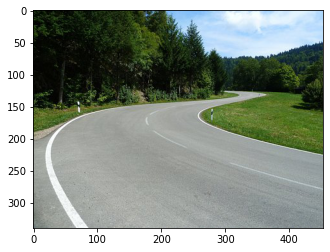

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

#importing some useful packages
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os



#reading in an image
image = mpimg.imread('/content/drive/MyDrive/APSCarVis/Data/road-71459__340.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', 
                   # for example, call as plt.imshow(gray, cmap='gray')




This image is: <class 'numpy.ndarray'> with dimensions: (340, 453, 3)


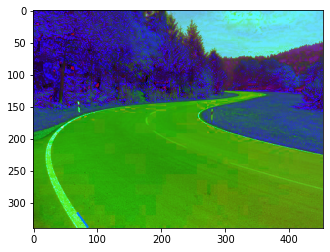

In [ ]:
hls=to_hls(image)
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(hls)

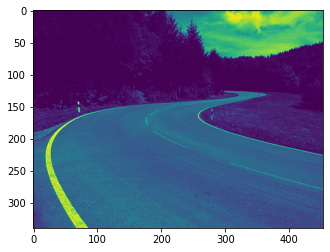

In [ ]:
grey_img = grayscale(image)
darken = adjust_gamma(grey_img,0.4)

plt.imshow(darken)

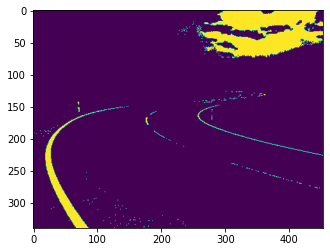

In [ ]:
white_m = isolate_color_mask(image, np.array([210, 210, 210], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8))
yellow_m = isolate_color_mask(image, np.array([190, 190, 0], dtype=np.uint8), np.array([255, 255, 255], dtype=np.uint8))

plt.imshow(yellow_m)

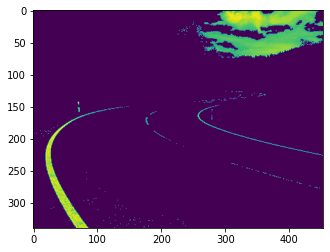

In [ ]:
mask = cv2.bitwise_or(white_m, yellow_m)
prep= cv2.bitwise_and(darken, darken, mask=mask)

plt.imshow(prep)

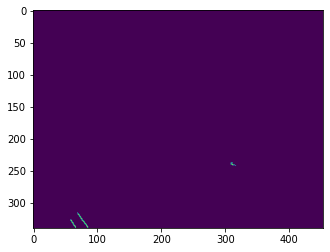

In [ ]:
blur = gaussian_blur(prep, kernel_size=7)
c_img= canny(blur, low_threshold=10, high_threshold=90)
final=get_aoi(c_img)

plt.imshow(final)

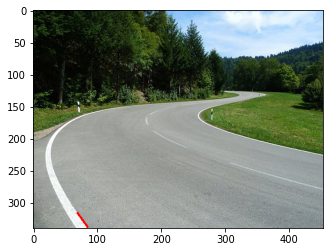

In [ ]:
line = get_hough_lines(final)

post= draw_lines(image,line)

plt.imshow(post)
plt.savefig('nondash.png')

# Primary Model

The best model that we have devised so far for our task of lane and **WHATEVER OBJECT WE CHOOSE** detection is one that incorporates these major pennants:

- A ResNet transfer learning model

- Recursive Neural Network add-on that stores previous frames to help inform decisions on the current frame.

These seem to help inform the model best, especially in situations where the lanes are less visibly marked, or there is significant obstruction.

The RNN implementation is something that is proven to work through the research paper from which we took the idea from.

The basic general idea behind our model is that we want it to be adept at cutting out noise.

A CNN is a trivial choice for such a image-based classification project, though if we are to analyze the functionalities of the task that needs to be performed, we realize what we are asking is not so trivial.

When it comes to real-life situations, there are many factors to account for, such as camera blur, light flares, other cars that may share similar color to the lanes/objects, pedestrians with bright colored clothing, or objects on the road, to name a few of the possible factors that our model would need to account for. This means that we want to be able to really focus in on what is important in any image, and for this a Autoencoder/VAE would do the job well. Currently the model is implementing a regular Autoencoder, though we may experiment with a VAE in the future.

We are using transfer learning from mobile net + fully connected layers to build a regression model that outputs 8 coefficients (4 for each lane)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class LaneDetectionModel(nn.Module):
    def __init__(self):
        super(LaneDetectionModel, self).__init__()
        self.features = models.vgg16(pretrained=True).features
        self.maxpool = nn.MaxPool2d((7, 7))
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 8)

    def forward(self, x):
        x = self.features(x)
        x = self.maxpool(x)
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LaneDetectionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#Cubic Fit

from scipy.optimize import curve_fit
import math

def func(x, a,b,c, d):
    return a*(x**3) + b*(x**2) + c*x + d


def cubic_fit(x,y):
  p0 = [] #initial Guesses
  popt, pconv = curve_fit(func, x, y, p0)

  print(popt[0])
  print(popt[1])
  print(popt[2])
  print(popt[3])


return popt


chi_squared = 0
for i in range(len(x)):
    if (i != 0 and func(x[i], *popt)!= 0 and x[i] != 0):
        chi_squared += ((y[i] - func(x[i], *popt)) / func(x[i], *popt)) ** 2
print(chi_squared / (len(x)  - 4))


In [ ]:
def lane_train(model, data, batch,  epochs, lr):

  """
  model: the nn
  data: should contain the images and coefficients 
  """
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr)
  train_loss = [] #could add validation and training losses
  t_loss = [] #loss for the entire curve

  for epoch in epochs: #purely comparing coefficients 
    for image, coords in data:
      label = cubic_fit(coords[0], coords[1]) #x and y 
      optimizer.zero_grad()
      pred = optimizer(image)
      loss = criterion (pred, label)
      loss.backward()
      optimizer.step()
    train_loss.append(loss)
  
  #comparing entire line
  x = np.array(list(range(1,1081))) # 1 coordinate for each pixel 

  for epoch in epochs:
    for image, coords in data:
      y_pred = func(x, model(image)[0])
      y_label = func(x,cubic_fit(coords[0], coords[1]) )
      optimizer.zero_grad()
      pred = optimizer(image)
      loss = criterion (y_pred, y_label)
      loss.backward()
      optimizer.step()
    t_loss.append(loss)
  """
  Okay so basically for the we can compute the loss of the coefficients, 
  or we can compute the loss of the entire cubic function over some coordinates
  in the picture
  """

In [ ]:
def obj_train(model, train_loader, valid_loader,batch,  epochs, lr):
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)
  



# Post Data Processing and Final output
